The Analysis in this notebook is mainly on: 
1. Plotting scatterplots of pre vs post (from various ROI's) and avg/max target/competitor


# Setup

In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline

from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText


# import torch
# import torchvision.models as models
# import torch.nn as nn
# import torchvision.transforms as transforms
# import torch.nn.functional as F
# from torch.autograd import Variable
# import sys
# sys.path.insert(0, '/home/rslee/sketchfeat/sketches')


# import embedding as emb
# reload(emb)
# from embedding import *


import pandas as pd
import pickle

VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3

ROI_all = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 
            'PRC', 'ento', 'hipp', 'mOFC', 'IFG', 'rostMFG', 
            'caudMFG', 'precentral', 'SMG', 'STG']




In [2]:
# partial = pd.read_csv('/Users/rachellee/Documents/sketchfeat_data/partial_sketch_full.csv')
partial = pd.read_csv('/Users/sasha/Documents/sketchfeat_data/partial_sketch_full.csv')
partial['curr_winner'] = partial[['bed', 'bench', 'chair', 'table']].idxmax(axis = 1)
partial['tc_pair'] = partial[['target', 'competitor']].apply(
                                    lambda x: '{:s}/{:s}'.format(x[0], x[1]), axis = 1)
partial['trialID'] = partial[['wID', 'trial']].apply(
                                    lambda x: '{:s}_{:d}'.format(x[0], x[1]), axis = 1)


def convert_label_to_index(labels):
    labels[labels == 'bed'] = 9
    labels[labels == 'bench'] = 10
    labels[labels == 'chair'] = 11
    labels[labels == 'table'] = 12
    labels = [int(x) for x in labels]
    return labels
    
    
target_labels = convert_label_to_index(np.copy(partial['target'].values))
comp_labels = convert_label_to_index(np.copy(partial['competitor'].values))
controls = np.array([np.setdiff1d(np.arange(9,13), x) for x in np.column_stack([target_labels, comp_labels])])
control1 = controls[:,0]
control2 = controls[:,1]


partial['target_val'] = partial.values[np.arange(len(partial)), target_labels]
partial['competitor_val'] = partial.values[np.arange(len(partial)), comp_labels]
partial['control_val'] = np.mean(np.array([partial.values[np.arange(len(partial)), control1], partial.values[np.arange(len(partial)), control2]]), axis = 0)


In [3]:
neural_diff_raw = pd.read_csv('/Users/sasha/Documents/sketchfeat_data/neural_changes_by_surfroi_and_subject.csv')
# neural_diff_raw = pd.read_csv('/Users/rachellee/Documents/sketchfeat_data/neural_changes_by_surfroi_and_subject.csv')
##
# so looks like there will be one row per subject, and 4 columns per ROI. 
# trained_{roi} and control_{roi} are the anchored measures of representational change 
# for the trained and control conditions respectively. 
# tradiff_{roi} is the unanchored trained, and condiff_{roi} is control
#first column is ids of each subject, eg 0110171_neurosketch


# until jordan updates the neural_diff data, we'll only be using 31 subjects as opposed to 35 
missing_subj = np.setdiff1d(np.unique(partial['wID']), neural_diff_raw['IDs'])
mask = partial['wID'].isin(missing_subj)
partial = partial[~mask];



In [24]:
# output a df with rows of subjects + columns of ROI's with order 

neural_diff = pd.DataFrame(neural_diff_raw['IDs'])

for cond in ['trained', 'tradiff']:
    for roi in ROI_all:

        # create string for column name 
        layer_name = cond + '_' + roi


        # get sorted order 
        neural_diff[layer_name] = neural_diff_raw[layer_name]
 

# Getting max/avg

In [25]:
subjects = np.unique(partial['wID'])

data = []; 


for s_i, subj in enumerate(subjects): 

        
    partial_i = partial[(partial['wID'] == subj)]
    max_t = np.mean(partial_i.groupby('trial')['target_val'].max())

    max_c = np.mean(partial_i.groupby('trial')['competitor_val'].max())

    max_diff = max_t - max_c 
        
    avg_t = np.mean(partial_i['target_val'])
    avg_c = np.mean(partial_i['competitor_val'])
    avg_diff = avg_t - avg_c; 

    data.append([subj, max_t, max_c, max_diff, avg_t, avg_c, avg_diff])





In [26]:
df = pd.DataFrame(data, columns=('IDs', 
                                'max_target', 'max_competitor', 'max_diff', 
                                 'avg_target','avg_competitor', 'avg_diff'))


neural_diff = neural_diff.merge(df)



# plotting


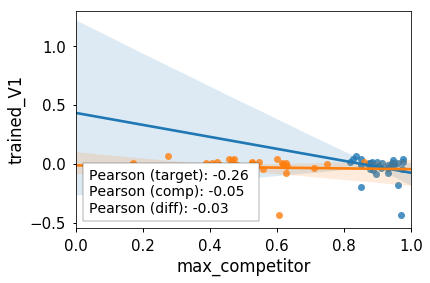

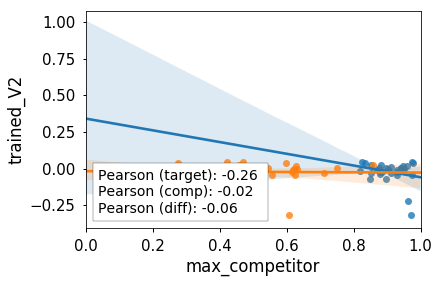

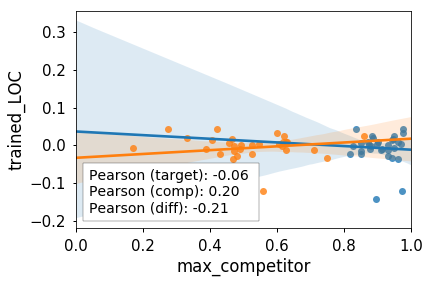

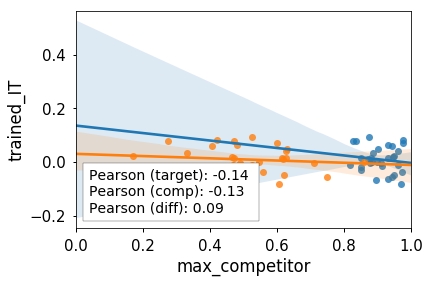

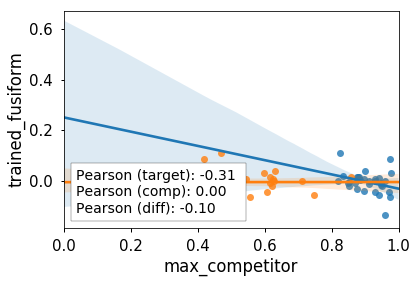

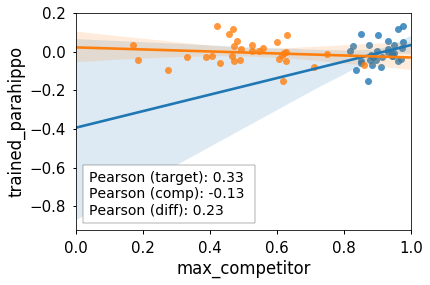

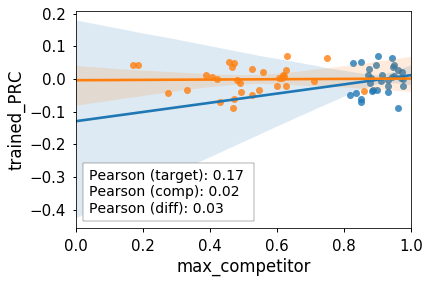

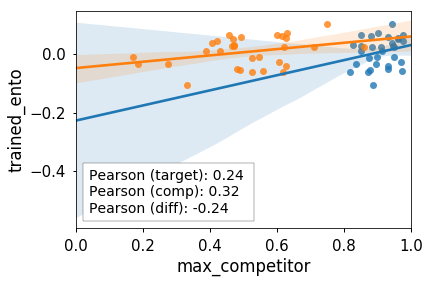

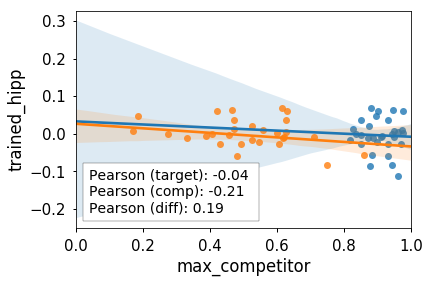

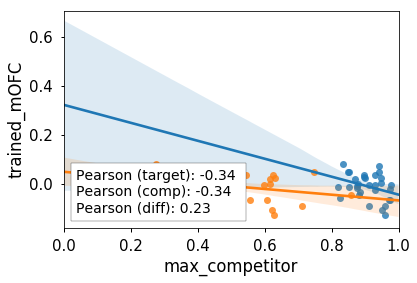

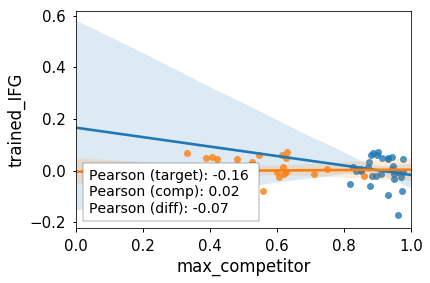

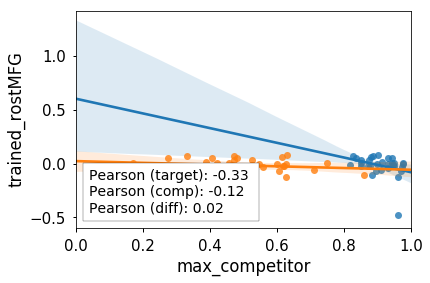

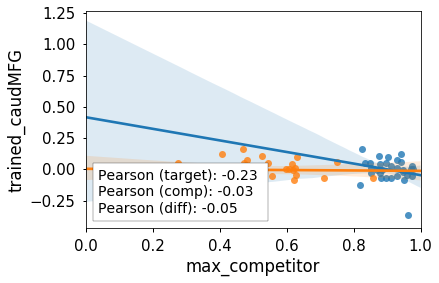

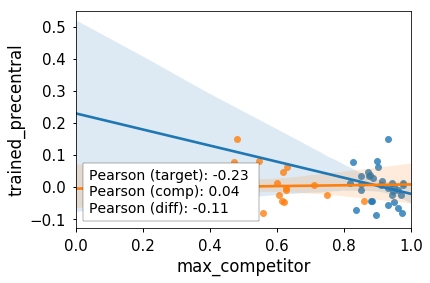

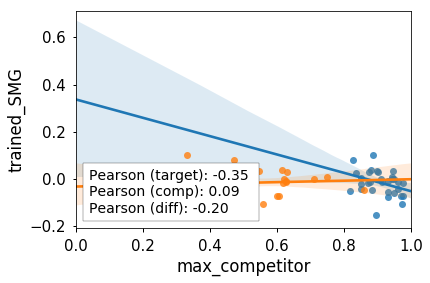

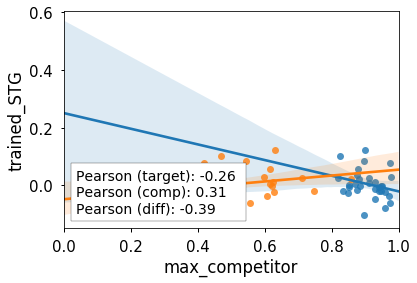

In [31]:


# for cond in ['trained', 'tradiff']:
if True:
    for roi_i, roi in enumerate(ROI_all):
        fig = plt.figure()
        cond = 'trained'; 
        
        layer_name = cond + '_' + roi
        axes = plt.gca()
        plt.xlim(0, 1.0)
        sns.regplot('max_target', layer_name, data=neural_diff)
        sns.regplot('max_competitor', layer_name, data=neural_diff)


        at_corr = AnchoredText('Pearson (target): {:.2f} \nPearson (comp): {:.2f} \nPearson (diff): {:.2f}'.format(
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['max_target'])[0], 
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['max_competitor'])[0], 
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['max_diff'])[0]),
                  prop=dict(size=14), frameon=True,
                  loc=3,
                  )


        axes = plt.gca()

        axes.add_artist(at_corr)
        
        plt.savefig('../sketchfeat_data/anchored/MAX_' + str(roi_i) + str(roi))


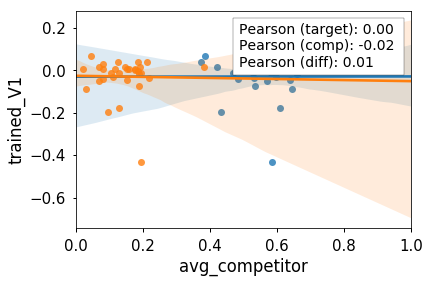

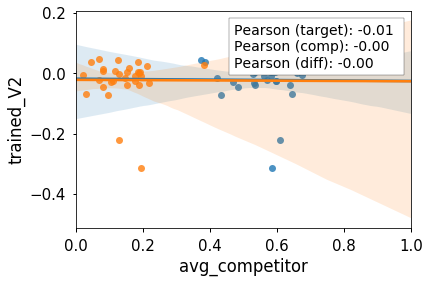

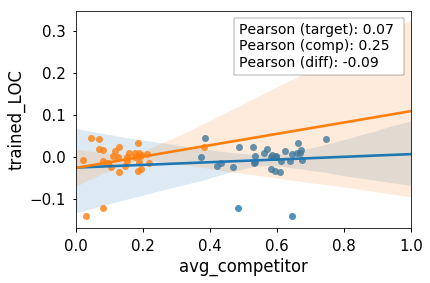

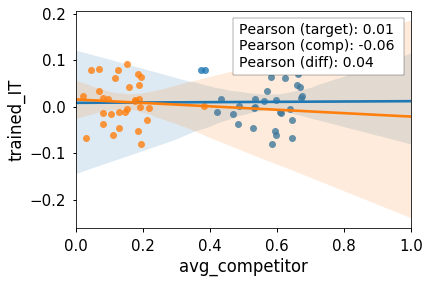

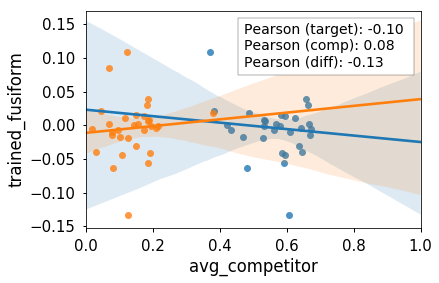

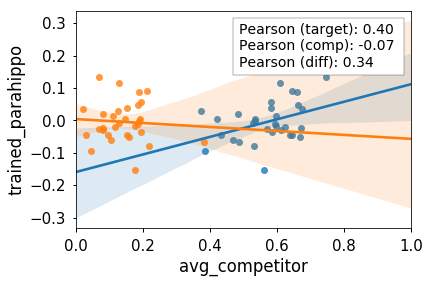

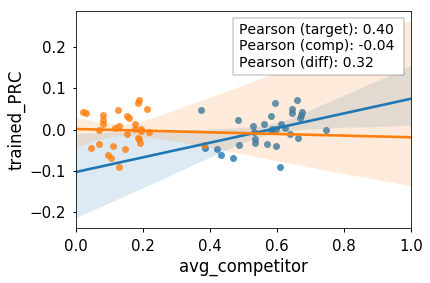

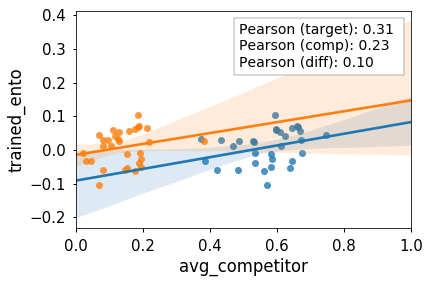

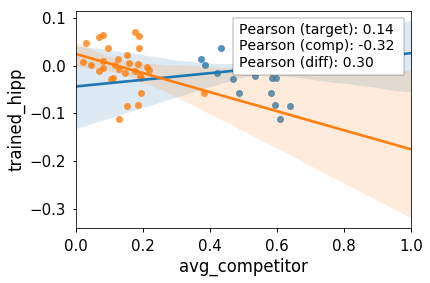

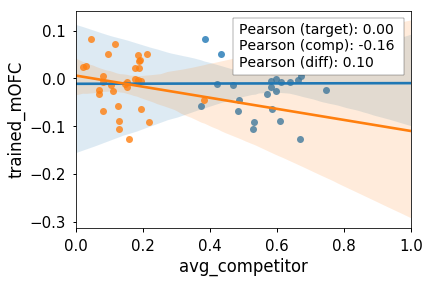

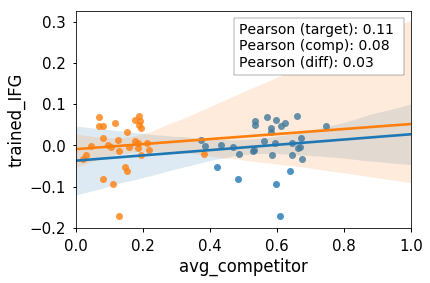

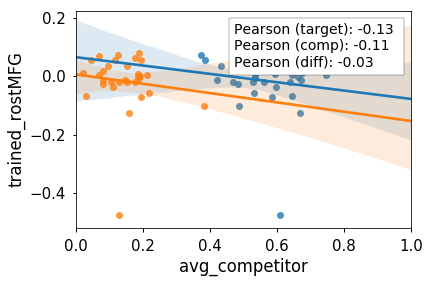

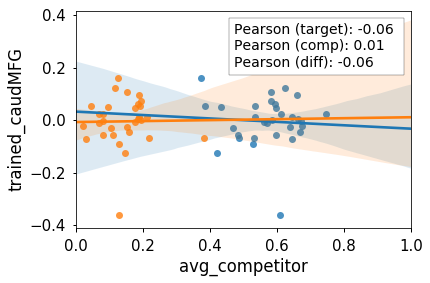

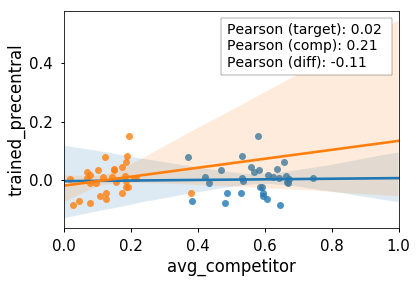

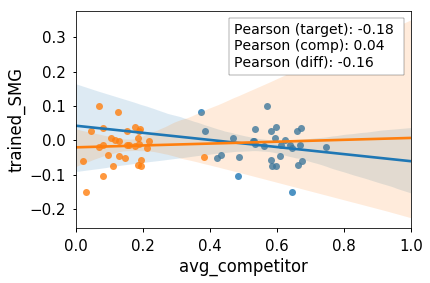

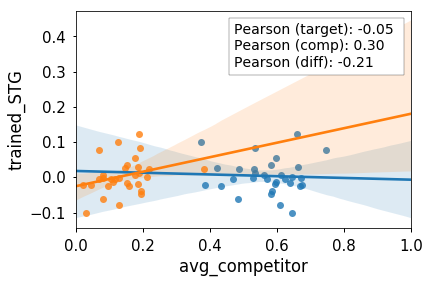

In [11]:


# for cond in ['trained', 'tradiff']:
if True:
    for roi_i, roi in enumerate(ROI_all):
        fig = plt.figure()
        cond = 'trained'; 
        
        layer_name = cond + '_' + roi
        axes = plt.gca()
        plt.xlim(0, 1.0)
        sns.regplot('avg_target', layer_name, data=neural_diff)
        sns.regplot('avg_competitor', layer_name, data=neural_diff)


        at_corr = AnchoredText('Pearson (target): {:.2f} \nPearson (comp): {:.2f} \nPearson (diff): {:.2f}'.format(
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['avg_target'])[0], 
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['avg_competitor'])[0], 
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['avg_diff'])[0]),
                  prop=dict(size=14), frameon=True,
                  loc=1,
                  )



        axes.add_artist(at_corr)
        plt.savefig('../sketchfeat_data/anchored/AVG_' + str(roi_i) + str(roi))



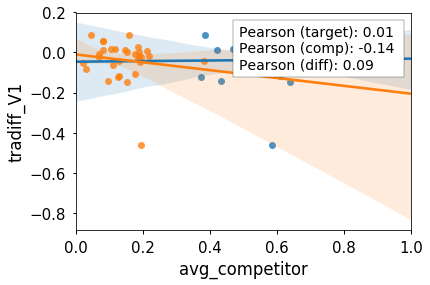

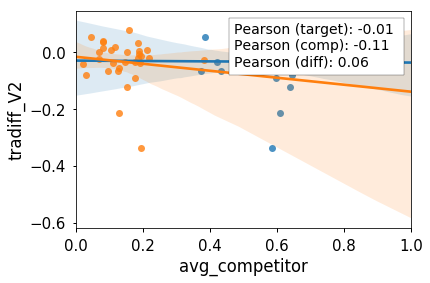

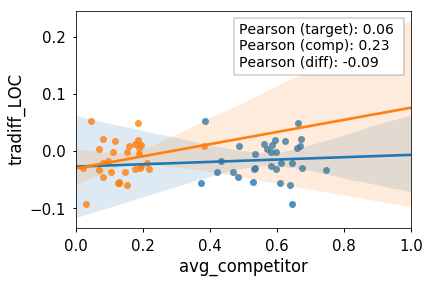

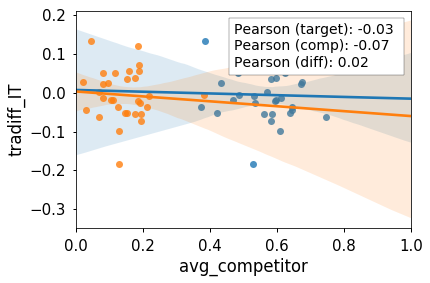

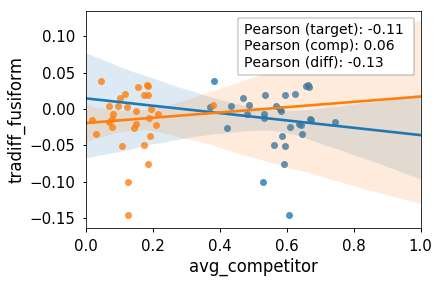

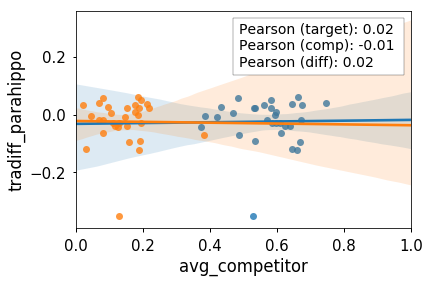

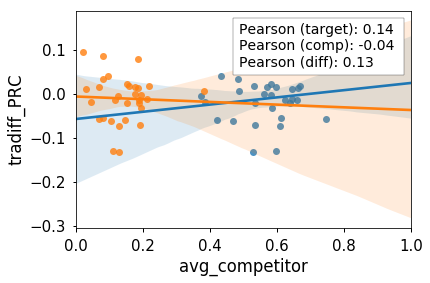

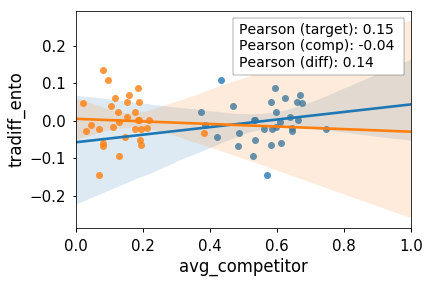

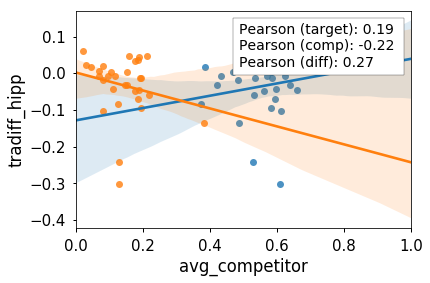

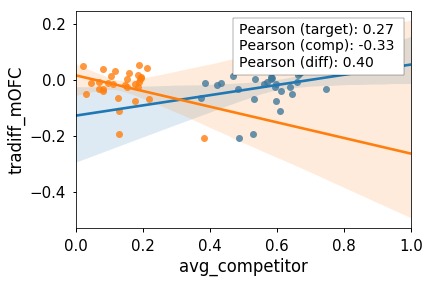

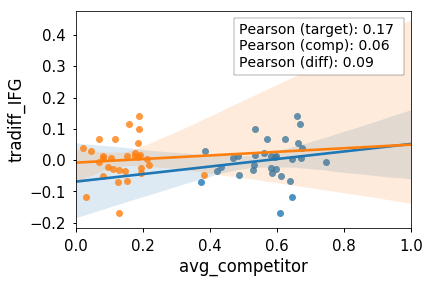

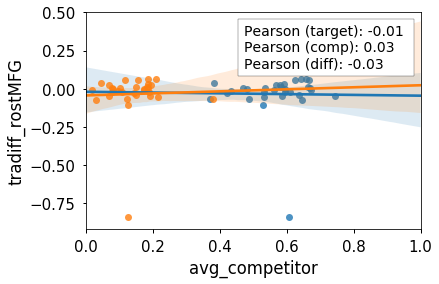

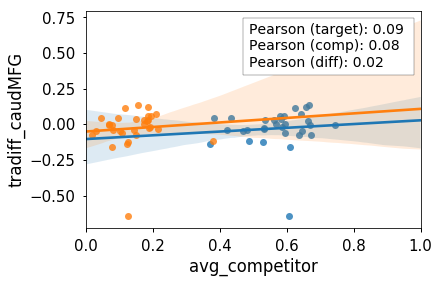

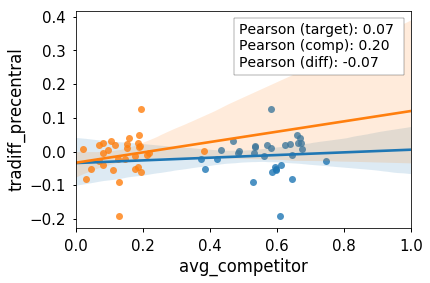

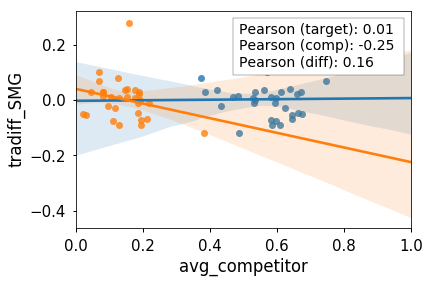

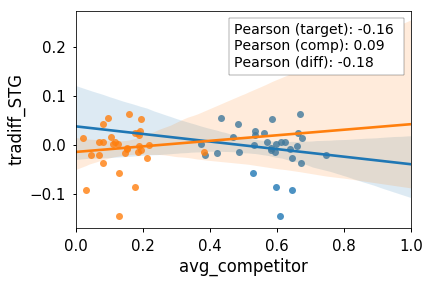

In [12]:


# for cond in ['trained', 'tradiff']:
if True:
    for roi_i, roi in enumerate(ROI_all):
        fig = plt.figure()
        cond = 'tradiff'; 
        
        layer_name = cond + '_' + roi
        axes = plt.gca()
        plt.xlim(0, 1.0)
        sns.regplot('avg_target', layer_name, data=neural_diff)
        sns.regplot('avg_competitor', layer_name, data=neural_diff)


        at_corr = AnchoredText('Pearson (target): {:.2f} \nPearson (comp): {:.2f} \nPearson (diff): {:.2f}'.format(
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['avg_target'])[0], 
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['avg_competitor'])[0], 
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['avg_diff'])[0]),
                  prop=dict(size=14), frameon=True,
                  loc=1,
                  )



        axes.add_artist(at_corr)
        plt.savefig('../sketchfeat_data/unanchored/AVG_' + str(roi_i) + str(roi))



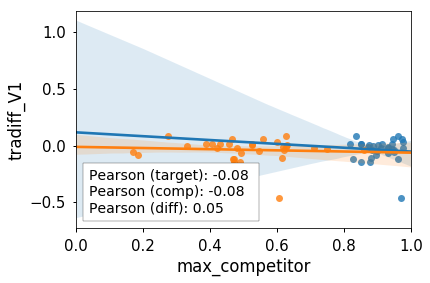

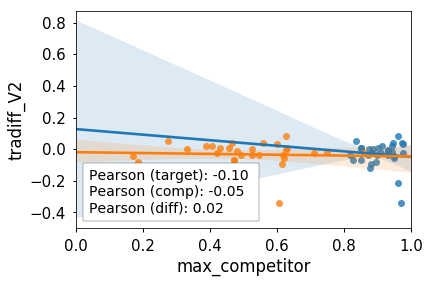

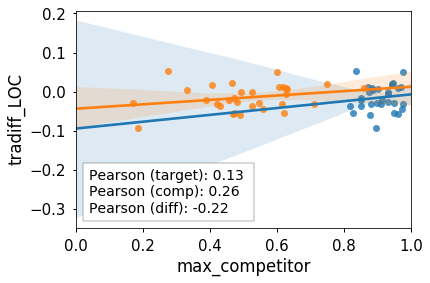

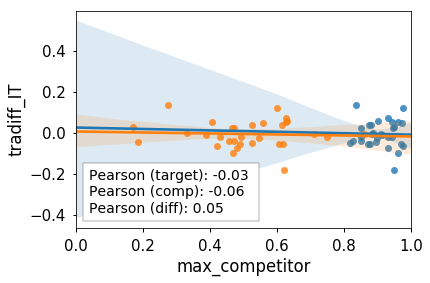

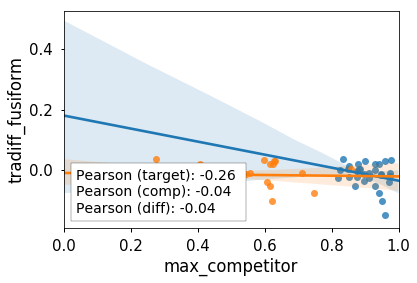

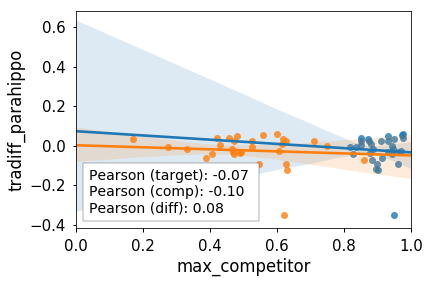

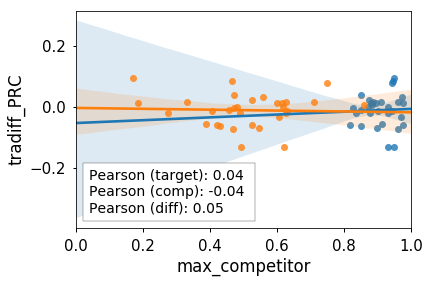

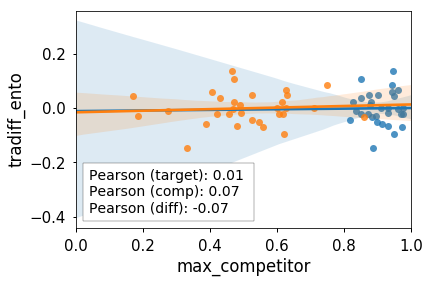

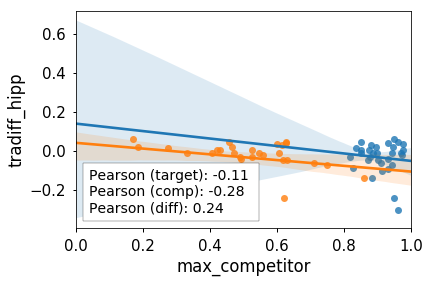

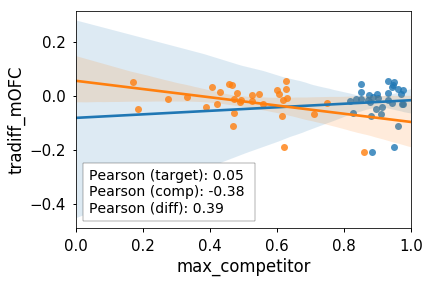

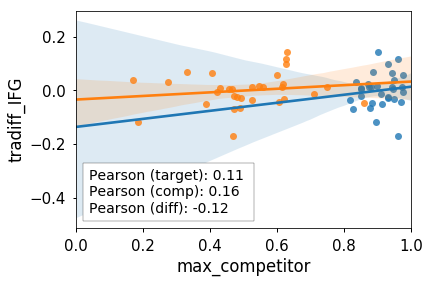

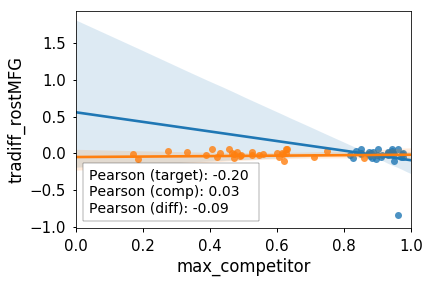

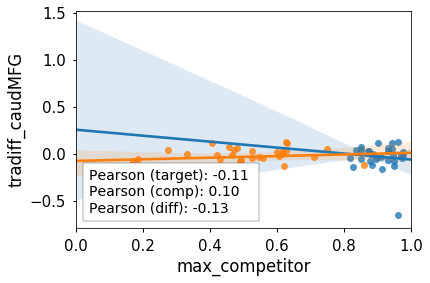

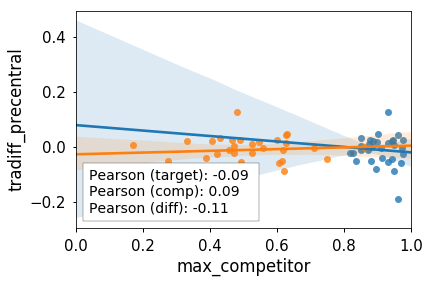

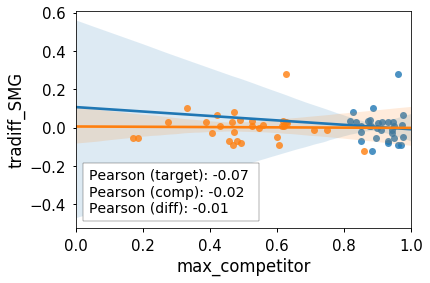

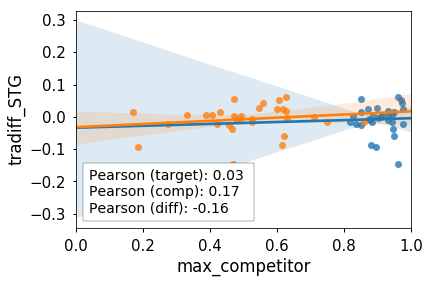

In [32]:


# for cond in ['trained', 'tradiff']:
if True:
    for roi_i, roi in enumerate(ROI_all):
        fig = plt.figure()
        cond = 'tradiff'; 
        
        layer_name = cond + '_' + roi
        axes = plt.gca()
        plt.xlim(0, 1.0)
        sns.regplot('max_target', layer_name, data=neural_diff)
        sns.regplot('max_competitor', layer_name, data=neural_diff)


        at_corr = AnchoredText('Pearson (target): {:.2f} \nPearson (comp): {:.2f} \nPearson (diff): {:.2f}'.format(
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['max_target'])[0], 
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['max_competitor'])[0], 
            scipy.stats.pearsonr(neural_diff[layer_name], neural_diff['max_diff'])[0]),
                  prop=dict(size=14), frameon=True,
                  loc=3,
                  )


        axes.add_artist(at_corr)
        
        plt.savefig('../sketchfeat_data/unanchored/MAX_' + str(roi_i) + str(roi))
